# Kaggle Titanic Competition

This notebook uses the Titanic sample dataset to go through a few standard data science / machine learning steps. The goal of this example is to provide a standard set of steps that can be used across many different use cases.
We will apply the CRISP-DM process of:

- Business Understanding
- Data Understanding
- Data Preparation
- Modeling
- Evaluation
- Deployment

### 1. Business Understanding:
The goal is simple for this exercise; It is to figure out how to accurately predict the survival rate of the Titanic passengers
### 2. Data Understanding: 
Let's load the data and take a quick glance of all the columns

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("train_original.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# We can quickly see, age is missing some data, so does Cabin, and also 2 empty for Embarked. 
# Let's quickly see if there's any relationship, betweens the survived columns with any of thees other individual features
# For all the category features (i.e. Surived, Pclass, Sex, etc), we will do a countPlot using survival as hue
# For the numeric features, we can do a histogram for each and again, using survival as hue.
# For PassengerId and Name, let's ignore for now as they are likely not meaningful as a feature to the survival
# The Ticket column may worth antoher look, not sure if there are any meaning or pattern. Also ignore for now.
# The Cabin column has many different values, we'll also take a differnet look at that one later.

import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
targetColumn = 'Survived'
catColumns = ['Embarked', 'Sex', 'Pclass']
numColumns = ['Age', 'Fare', 'SibSp', 'Parch']

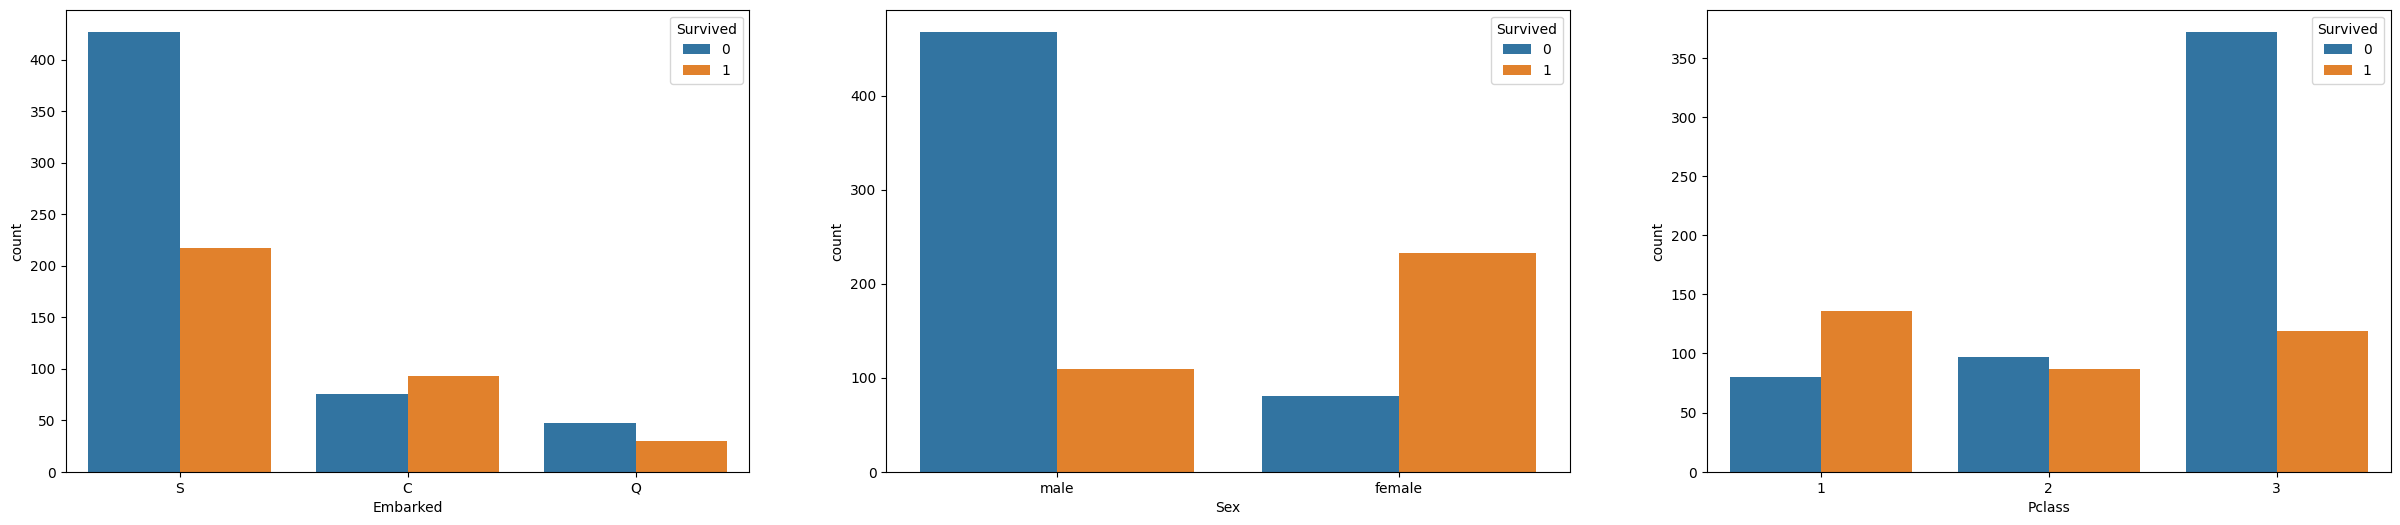

In [5]:
# Visualize relationship between categorical columns and survival
colCount = 3
rowCount = 1
fig, axs = plt.subplots(rowCount, colCount, figsize=(30,6))
currCol = 0
currRow = 0
for i in range(len(catColumns)):
    sns.countplot(x=catColumns[i], data=df, hue=targetColumn, ax=axs[currCol])
    currCol += 1
    if (currCol >= colCount):
        currCol = 0
        currRow += 1

plt.show()

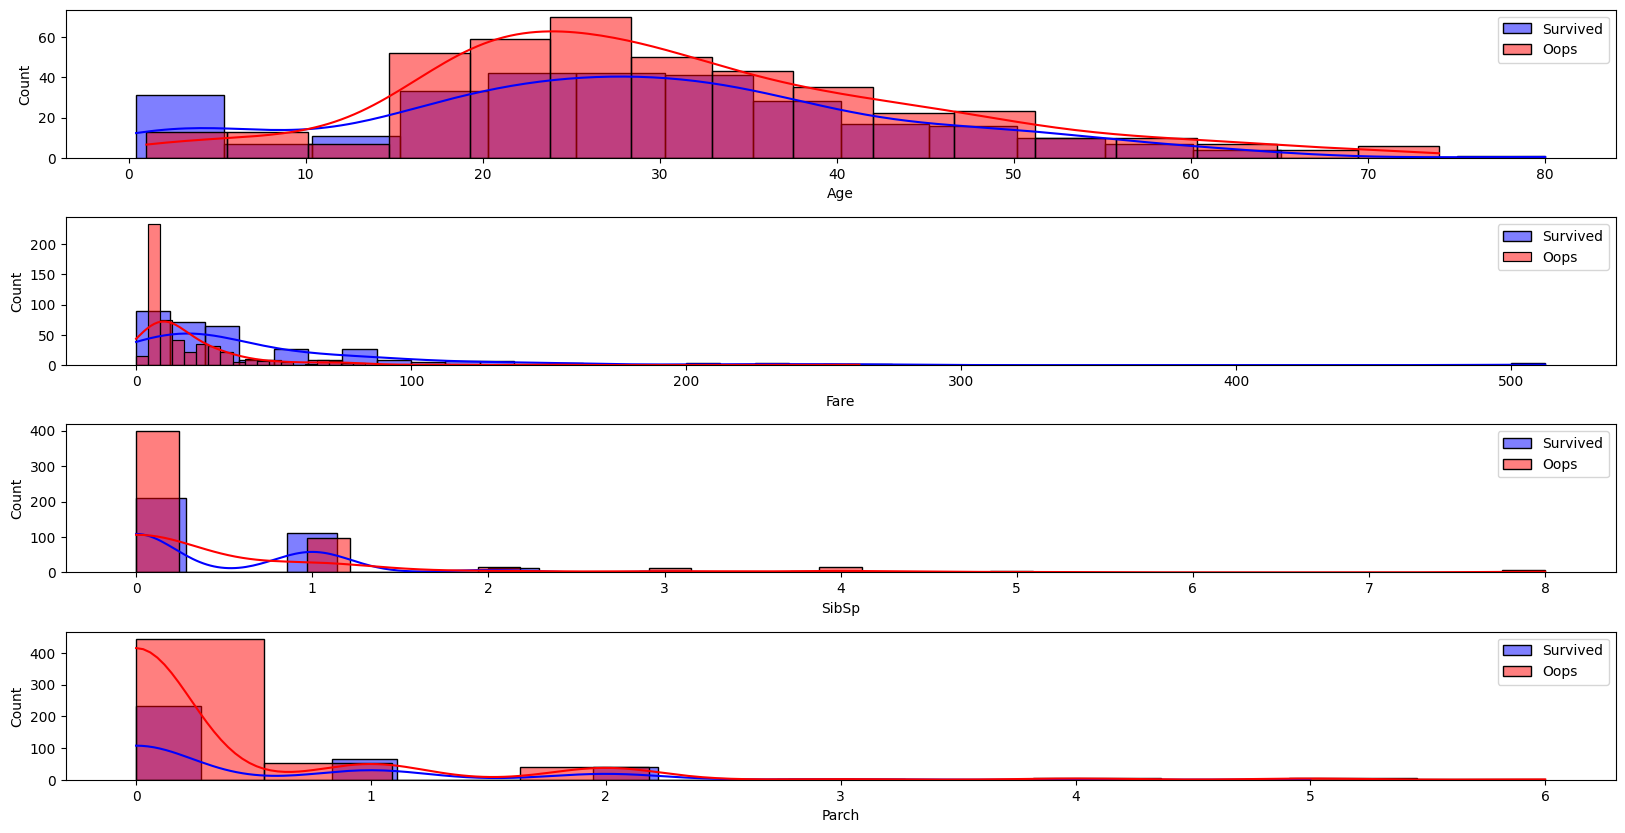

In [6]:
# So there is some very clear relations we can see now. Things that suggests high fatality includes Embarking from S (Southampton), male, people who have no
# parent or children (parch=0), and class = 3.
colCount = 1
rowCount = 4
fig, axs = plt.subplots(rowCount, colCount, figsize=(20,10))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
currRow = 0
currCol = 0
for i in range(len(numColumns)):
    sns.histplot(df[df[targetColumn] == 1][numColumns[i]], label="Survived", ax=axs[currRow], kde=True, color="blue", alpha=0.5)
    sns.histplot(df[df[targetColumn] == 0][numColumns[i]], label="Oops", ax=axs[currRow],  kde=True, color="red", alpha=0.5)
    currRow += 1
    axs[i].legend()

plt.show()

## 3. Data Preparation
Generally we will need to do a couple things:
- One hot encode the categorical features
- Handle any missing values
- Scale the numberic features

In this particular data set, from the charts above we can see a couple intuitive insights. For the categorical features, embarked, sex, and Pclass, a standard one hot encoding should be a good pre-processing step.
For the age, the shape of the survival trend for people, shows that young kids from around 0-5, has a much higher rate of survival. Instead of just scaling the age, it may be better to just treat it as a True False, of whether passenger is someone younger than five.
Similar for sibling or spouse, and parch. If you don't have any, you have a much higher chance of dying. We'll create a new column for whether this is 0 too.
Fares, we can probably just scale it normally.


In [7]:
# We will create a function for preprocessing the titanic data. This way, when we need to predict test data
def titanic_pre_process(df, dropNA = True):
    # One hot encode Embarked, Sex, and Pclass
    df_prep = pd.get_dummies(df, columns=['Embarked', 'Sex', 'Pclass'])
    
    #We want to drop null values when training, but not for test data.
    if dropNA:        
        df_prep = df_prep.dropna(subset=['Age'])
    
    #Generate new features based on our intuition of siblings, families, and age
    df_prep["haveSib"] = df_prep['SibSp'].apply(lambda x: 1 if x > 0 else 0)
    df_prep["haveParch"] = df_prep['Parch'].apply(lambda x: 1 if x > 0 else 0)
    df_prep["isKid"] = df_prep['Age'].apply(lambda x: 1 if x <= 5 else 0)
    
    #Drop unused columns for modeling
    df_prep = df_prep.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Age'], axis=1)
    
    return df_prep


In [8]:
df = titanic_pre_process(df)

In [9]:
df.head()

,Survived,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,haveSib,haveParch,isKid
0,0,7.2500,0,0,1,0,1,0,0,1,1,0,0
1,1,71.2833,1,0,0,1,0,1,0,0,1,0,0
2,1,7.9250,0,0,1,1,0,0,0,1,0,0,0
3,1,53.1000,0,0,1,1,0,1,0,0,1,0,0
4,0,8.0500,0,0,1,0,1,0,0,1,0,0,0


## 4. Modeling
We will use scikit learn's machine learning model and pipeline. We will first split the data we have into train and test data, run cross validation, and then try various machine learning models and see what works best.
- Train / Test split
- Build pipline to:
 - Scale the input
 - Fit the train data
 - Score the mode

In [10]:
# Now come the final step, let's scale the Fare.
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import xgboost as xgb


In [11]:
X = df.drop(['Survived'], axis=1)
y = df[['Survived']]

In [12]:
X.head()

,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,haveSib,haveParch,isKid
0,7.2500,0,0,1,0,1,0,0,1,1,0,0
1,71.2833,1,0,0,1,0,1,0,0,1,0,0
2,7.9250,0,0,1,1,0,0,0,1,0,0,0
3,53.1000,0,0,1,1,0,1,0,0,1,0,0
4,8.0500,0,0,1,0,1,0,0,1,0,0,0


In [13]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
standard_transformer = Pipeline(steps=[
        ('standard', StandardScaler())])

preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', standard_transformer , ['Fare'])            
        ])

In [16]:
classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10),
    AdaBoostClassifier(),
    xgb.XGBClassifier(objective='binary:logistic', n_estimators=10)
]

In [17]:
for classifier in classifiers:
    steps = [('Preprocess', preprocessor),
            ('classifier', classifier)]

    print("Training "  + type(classifier).__name__)
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print("Classifier " + type(classifier).__name__ + ", has a score of ",  accuracy_score(y_test, y_pred), "\n")
    
    

Training KNeighborsClassifier
Classifier KNeighborsClassifier, has a score of  0.7832167832167832 

Training DecisionTreeClassifier
Classifier DecisionTreeClassifier, has a score of  0.7832167832167832 

Training RandomForestClassifier
Classifier RandomForestClassifier, has a score of  0.7692307692307693 

Training AdaBoostClassifier
Classifier AdaBoostClassifier, has a score of  0.8041958041958042 

Training XGBClassifier


/apps/python3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/apps/python3/lib/python3.7/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/apps/python3/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/apps/python3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this

[19:13:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier XGBClassifier, has a score of  0.7692307692307693 



## 5. Evaluation and Deploy
Looks like AdaBoost is a decent model. Let's create an output file and submit it to Kaggle and see what we get.

In [18]:
test_df = pd.read_csv("test.csv")
testPID = pd.DataFrame(test_df["PassengerId"])
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
test_df = titanic_pre_process(test_df, dropNA=False)

In [20]:
test_df.head()

,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,haveSib,haveParch,isKid
0,7.8292,0,1,0,0,1,0,0,1,0,0,0
1,7.0000,0,0,1,1,0,0,0,1,1,0,0
2,9.6875,0,1,0,0,1,0,1,0,0,0,0
3,8.6625,0,0,1,0,1,0,0,1,0,0,0
4,12.2875,0,0,1,1,0,0,0,1,1,1,0


In [21]:
#We need to handle any missing data in the test before we can run predict.
test_df.isna().sum()

Fare          1
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Sex_female    0
Sex_male      0
Pclass_1      0
Pclass_2      0
Pclass_3      0
haveSib       0
haveParch     0
isKid         0
dtype: int64

In [22]:
# This time, we will train with ALL the data we have, using the model we believe is best.
# And looks like it's missing a fare... we'll just impute it.
from sklearn.impute import SimpleImputer

classifier = DecisionTreeClassifier(max_depth=10)
steps = [('Preprocess', preprocessor),
         ('Impute', SimpleImputer()),
            ('classifier', classifier)]
pipeline = Pipeline(steps)
pipeline.fit(X, y)
y_pred = pipeline.predict(X)
print("Using all data we have, classifier " + type(classifier).__name__ + ", has a score of ",  accuracy_score(y, y_pred), "\n")

Using all data we have, classifier DecisionTreeClassifier, has a score of  0.8795518207282913 



In [23]:
test_pred = pipeline.predict(test_df)

In [24]:
submission_df = pd.DataFrame(testPID["PassengerId"], columns=["PassengerId"])

In [25]:
submission_df["Survived"] = test_pred 

In [26]:
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [27]:
submission_df.to_csv("titanic_pred_jun30.csv", index=False)

In [28]:
#This got us a score of about 0.78. 